<a href="https://colab.research.google.com/github/peppefdf/Generate_stops/blob/main/Generate_stops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Point density function for cluster:  0


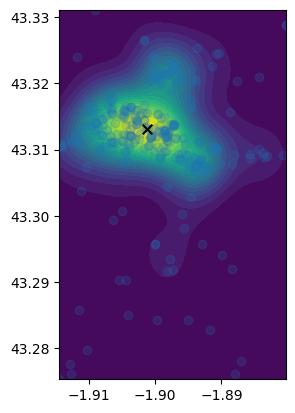

<ipython-input-25-6c4ccad4734c>:37: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
<ipython-input-25-6c4ccad4734c>:41: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
<ipython-input-25-6c4ccad4734c>:53: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  eroded_background = morphology.binary_erosion(


Local maxima for cluster:  0
[ 183.40858035  114.48790297   99.65610759  146.85582722  257.68989494
 4156.80829752  119.20131533   63.58203109]
Local maxima within 20% of absolute max:
43.31315566001053 -1.901187820667982

Point density function for cluster:  1


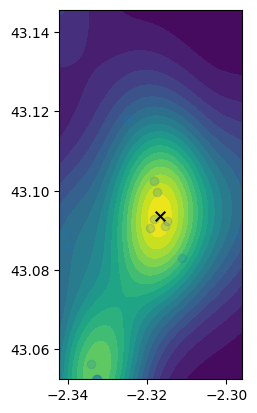

Local maxima for cluster:  1
[349.68672445 443.44559897  68.79802769]
Local maxima within 20% of absolute max:
43.054938993446804 -2.3325325074584304
43.09373703467132 -2.316732825584902

Point density function for cluster:  2


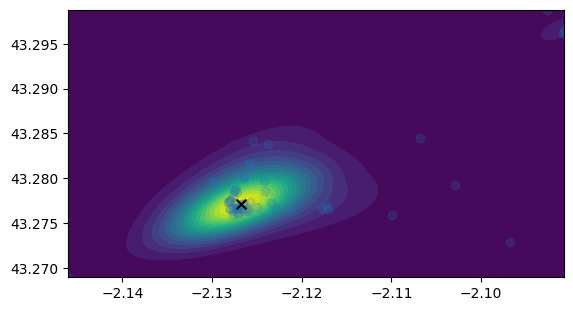

Local maxima for cluster:  2
[  306.80827196   299.84709207   476.79978755 11197.06840976
   477.16062181   664.96855405]
Local maxima within 20% of absolute max:
43.27717700052014 -2.126761024168712

Point density function for cluster:  3


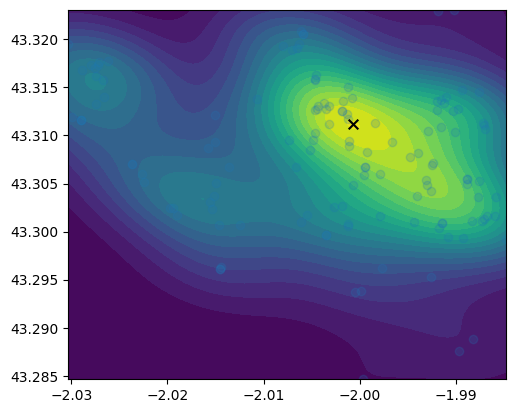

Local maxima for cluster:  3
[ 720.15384315 1603.49975427  731.14786568]
Local maxima within 20% of absolute max:
43.30347430736079 -2.0162833508613187
43.311215269475035 -2.0006940353952394
43.3156018146731 -2.0275932463955333

Point density function for cluster:  4


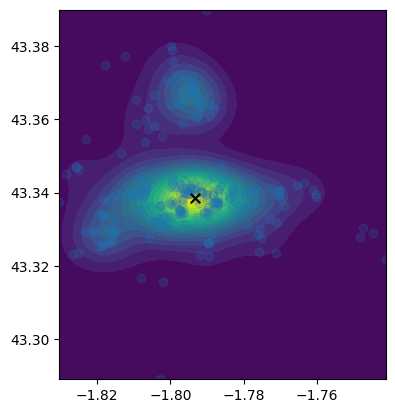

Local maxima for cluster:  4
[  18.38633642   57.4322996  1396.34594893  529.56971452]
Local maxima within 20% of absolute max:
43.33844900983549 -1.7932983977255943
43.366171131313926 -1.7944925003007022

Point density function for cluster:  5


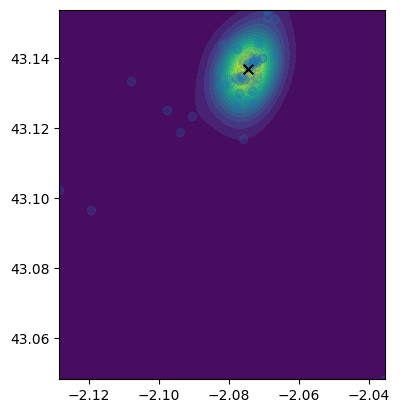

Local maxima for cluster:  5
[  61.86705759   71.13313273   71.09531055   64.39259145 3176.9389363 ]
Local maxima within 20% of absolute max:
43.13675570258261 -2.074699916145996

Point density function for cluster:  6


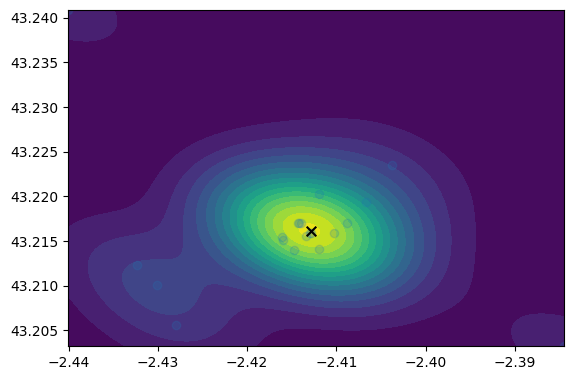

Local maxima for cluster:  6
[ 271.7758981   691.76398986 3238.25476922  271.29790652]
Local maxima within 20% of absolute max:
43.209774656307495 -2.4300002967474783
43.21609827417579 -2.4128493539905644

Point density function for cluster:  7


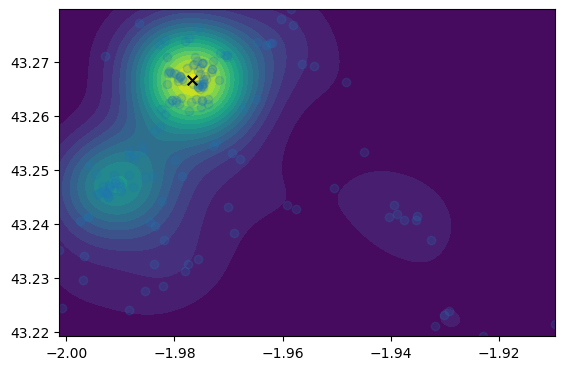

Local maxima for cluster:  7
[  81.97862944  151.04704071  734.65289334 1373.9298979 ]
Local maxima within 20% of absolute max:
43.24726853312373 -1.990863381328191
43.266768410393816 -1.9766883439493865

Point density function for cluster:  8


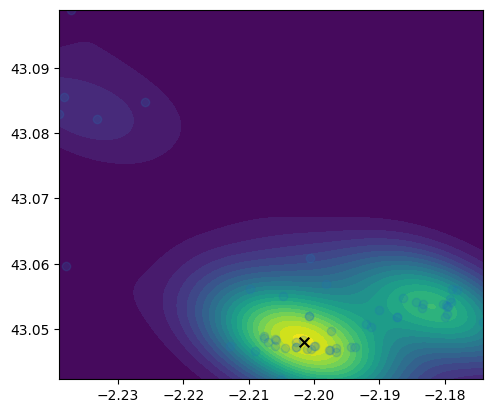

Local maxima for cluster:  8
[1619.67303738 1122.06847756   74.59351096  220.28582096   79.14549752]
Local maxima within 20% of absolute max:
43.0480436702496 -2.201602904265589
43.05335431617096 -2.1820536889478115

Point density function for cluster:  9


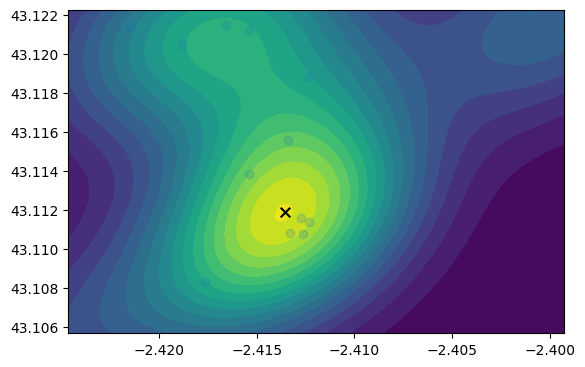

Local maxima for cluster:  9
[4268.70828834 2902.34909972 1462.89888484]
Local maxima within 20% of absolute max:
43.111908315777505 -2.413577592300912
43.120350184917335 -2.41664723164408
43.121572034398106 -2.4004463573329144

Point density function for cluster:  10


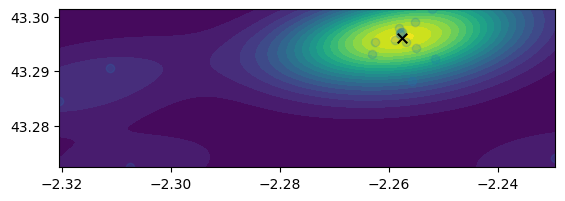

Local maxima for cluster:  10
[ 132.87152557  131.66339332  217.86586465 1535.51391713]
Local maxima within 20% of absolute max:
43.296118309290804 -2.2575370719981422

Point density function for cluster:  11


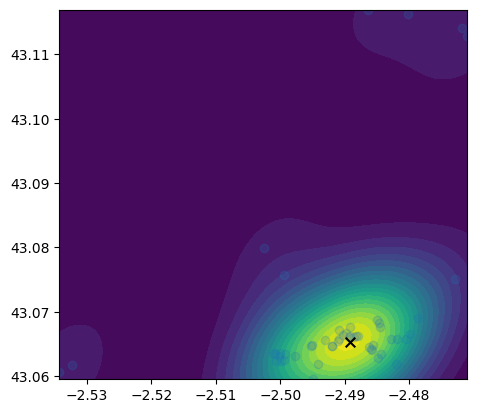

Local maxima for cluster:  11
[ 153.75896058 2031.67956393  175.30140716]
Local maxima within 20% of absolute max:
43.065289943401375 -2.489216776911826

Point density function for cluster:  12


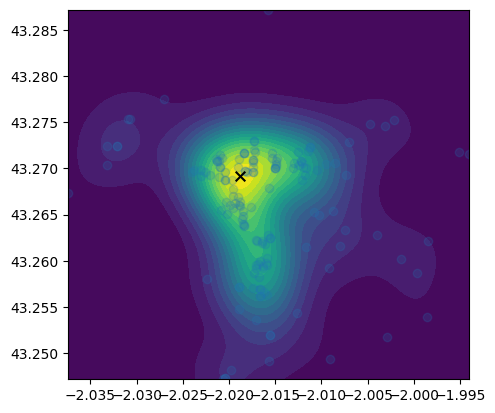

Local maxima for cluster:  12
[ 361.89564338  361.92891952 4679.65703773  240.05720689  585.65490493
  119.52611259]
Local maxima within 20% of absolute max:
43.26918391089853 -2.0187954957828813

Point density function for cluster:  13


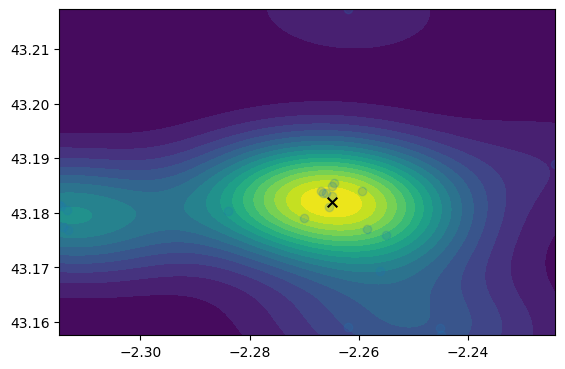

Local maxima for cluster:  13
[326.66114158 677.35500334  65.2487945 ]
Local maxima within 20% of absolute max:
43.17961459780958 -2.312389085760032
43.18201895292331 -2.2648451916716925

Point density function for cluster:  14


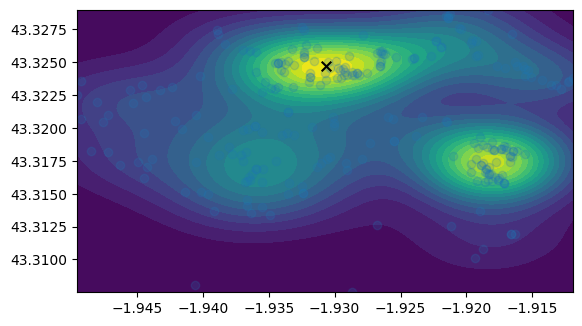

Local maxima for cluster:  14
[ 100.55514387   98.85375038 2238.68434975 4111.19721142 4482.05056773]
Local maxima within 20% of absolute max:
43.31701134954488 -1.9356756947822629
43.31744313654481 -1.9180029816776725
43.324639586543704 -1.9306263481809514

Point density function for cluster:  15


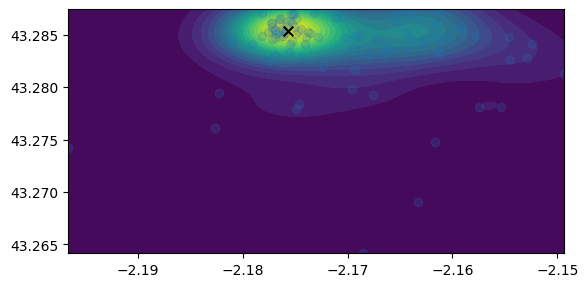

Local maxima for cluster:  15
[ 248.52323228  249.06601246  247.51243305  507.40349509 9962.33890582
 4637.85506833]
Local maxima within 20% of absolute max:
43.285379439932385 -2.175703380317751
43.285379439932385 -2.1639667719019453

Point density function for cluster:  16


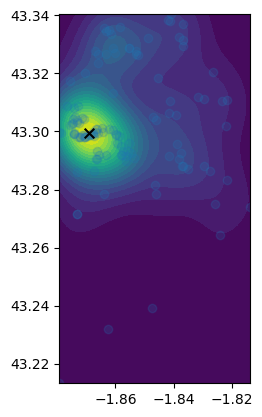

Local maxima for cluster:  16
[ 20.08726219  22.24174991  22.16948817 806.27196659 257.27056357]
Local maxima within 20% of absolute max:
43.29956242816611 -1.8692377884427493
43.32861588284958 -1.8604154687159569

Point density function for cluster:  17


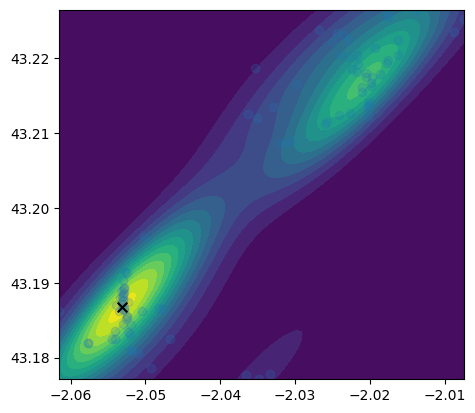

Local maxima for cluster:  17
[ 202.7422455  2160.21059096 1556.431187  ]
Local maxima within 20% of absolute max:
43.18672374301246 -2.0531502417666165
43.21689248004477 -2.0208360674341863

Point density function for cluster:  18


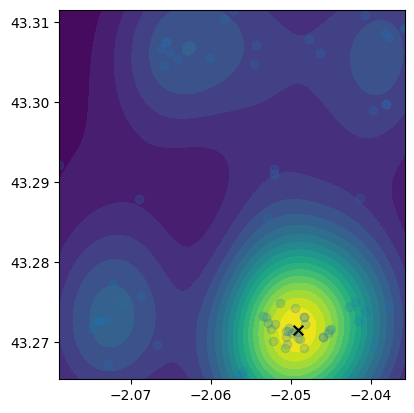

Local maxima for cluster:  18
[1438.14946246  441.28719274  356.45933401  402.08088512]
Local maxima within 20% of absolute max:
43.271525633604114 -2.049072818397233
43.27307618047484 -2.072565788716866
43.305637664759985 -2.0389215349257865
43.30656799288242 -2.062704541916032

Point density function for cluster:  19


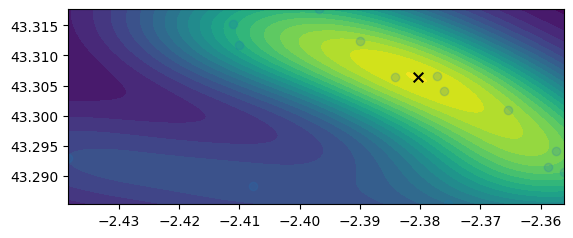

Local maxima for cluster:  19
[139.48878086 525.69679198]
Local maxima within 20% of absolute max:
43.28898809997437 -2.4097319146054303
43.30637555708846 -2.3804478594529286

Point density function for cluster:  20


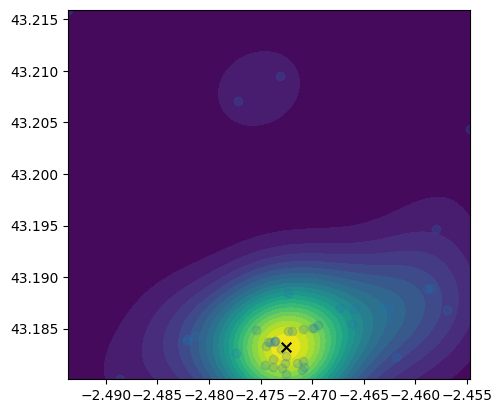

Local maxima for cluster:  20
[4930.83290505  219.04588205  352.60929811  208.75761451]
Local maxima within 20% of absolute max:
43.18321416175029 -2.4724803875637376

Point density function for cluster:  21


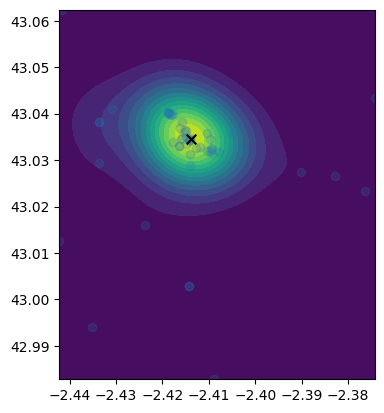

Local maxima for cluster:  21
[  70.64831284   70.99269739  144.25089136   72.9820733   148.59488824
 2110.94806931   71.59389081   69.95026029]
Local maxima within 20% of absolute max:
43.034610023811986 -2.413935903394556

Point density function for cluster:  22


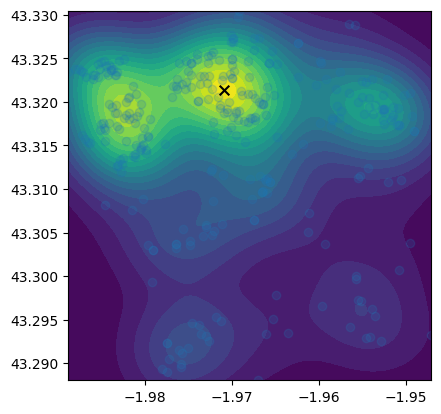

Local maxima for cluster:  22
[ 454.19269986  302.66554471 1652.90683558 1111.91586654 1837.37252447]
Local maxima within 20% of absolute max:
43.292027058574 -1.975111218569246
43.31879425310197 -1.982108439740934
43.31936376787916 -1.9538396662073148
43.32135706959933 -1.9709128858662333


























In [25]:
#%pip install osmnx

import numpy as np
import osmnx as ox
import pandas as pd
import folium
import random
import sklearn
from sklearn.cluster import KMeans
import geopy.distance
from scipy import stats
from scipy.interpolate import interp2d

import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

from matplotlib import pyplot as plt
from google.colab import drive

#n_skip = 10
n_clusters = 23
#dist_tol = 1000 # distance tolerance for bus_stop from cluster center (in meters)

workers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Accessibility_Map/workers_eskuzaitzeta_12_02_2024.csv", encoding='latin-1')
stops_df = df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/GTFS_files_bus_stops_12_02_2024/all_stops_12_02_2024.csv", encoding='latin-1')


def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    #
    # we create the mask of the background
    background = (arr==0)
    #
    # a little technicality: we must erode the background in order to
    # successfully subtract it from local_min, otherwise a line will
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    #
    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)


#lat_lon = workers_df[['O_lat', 'O_long']][::n_skip] # take every n elements
workers_lat_lon = workers_df[['O_lat', 'O_long']].values.tolist()

stops_lat_lon = stops_df[['stop_lat','stop_lon']].to_numpy()


ori_lat = 43.13525255625577
ori_lon = -2.080054227169231


model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(workers_lat_lon)
# assign a cluster to each example
yhat = model.predict(workers_lat_lon)

# retrieve unique clusters
clusters = np.unique(yhat)
centers = np.array(model.cluster_centers_)

#fig,ax = plt.subplots()

XY_hdp = []
cont_cluster = 0
highDens_points = []
for cluster in clusters:
 X = []
 Y = []
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)
 # create scatter of these samples
 dist = []
 for i_cl in range(len(row_ix[0])):

     # calculate Euclidean distance of each point from cluster center
     #d = sum((p-q)**2 for p, q in zip(centers[cont_cluster], workers_lat_lon[row_ix[0][i_cl]]))**.5
     #dist.append(d)
     X.append(workers_lat_lon[row_ix[0][i_cl]][0])
     Y.append(workers_lat_lon[row_ix[0][i_cl]][1])

 #centers_ref = np.tile(centers[cont_cluster],(len(row_ix[0]),1)) # generate replicas of cluster center coords.
 #dist = [geopy.distance.geodesic((p[0],p[1]), (q[0],q[1])).km for p, q in zip(centers_ref, np.array(workers_lat_lon)[row_ix[0]])]

 # find index of the point with minimum distance from cluster center
 #index_min = np.argmin(dist)
 # assign closest point to cluster center: this tries to avoid the cluster center to fall in the middle of nowhere
 #centers[cont_cluster][0] = workers_lat_lon[row_ix[0][index_min]][0]
 #centers[cont_cluster][1] = workers_lat_lon[row_ix[0][index_min]][1]
 #highDens_points.append(xymax)

 temp_array = np.array(workers_lat_lon)[row_ix[0]]
 Lats = [temp_array[i,0] for i in range(len(temp_array))]
 Lons = [temp_array[i,1] for i in range(len(temp_array))]

 minLat = min(Lats)
 maxLat = max(Lats)
 minLon = min(Lons)
 maxLon = max(Lons)

 xy = np.vstack([Y,X])
 kernel = stats.gaussian_kde(xy)
 x,y = np.mgrid[minLat:maxLat:150j, minLon:maxLon:150j]  # 100 x 100 grid for plotting
 z = kernel.pdf(np.array([y.ravel(),x.ravel()])).reshape(x.shape)
 indmax = np.unravel_index(np.argmax(z, axis=None), z.shape)  # returns a tuple
 highestDP = (x[indmax],y[indmax])
 highDens_points.append(highestDP)

 cont_cluster+=1

 print('Point density function for cluster: ', str(cluster))
 fig,ax = plt.subplots()
 ax.contourf(y, x, z, levels=20)
 ax.axis('scaled')
 plt.scatter(Y,X, marker = 'o', alpha=0.2)
 plt.scatter(highestDP[1], highestDP[0], s=48, marker="x", color='black')
 plt.savefig('/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Point_density_cluster_'+str(cluster)+'.png')
 plt.show()

 # find local maxima
 local_minima_locations = detect_local_minima(-z)
 print('Local maxima for cluster: ', cluster)
 print(z[local_minima_locations])
 maxs = z[local_minima_locations]
 ind_maxs = [i for i in range(len(maxs)) if maxs[i]/max(maxs)>=0.2]
 #for i_max in range(len(local_minima_locations[0])):
 print('Local maxima within 20% of absolute max:')
 for i_max in range(len(ind_maxs)):
     i_tmp = ind_maxs[i_max]
     x_coord = x.T.ravel()[local_minima_locations[0][i_tmp]]
     y_coord = y.ravel()[local_minima_locations[1][i_tmp]]
     print(x_coord, y_coord)
 print()
# plot centers
#centers = np.array(model.cluster_centers_)
#plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
#plt.show()


"""
tags = {'highway':'bus_stop',
        'bus':'yes',
        'unsigned':'yes',
        'public_transport':['stop_position','platform']}
"""
"""
tags = {'highway':'bus_stop',
        'bus':'yes'}
"""

bus_stops = []
center_ind = []
for i in range(len(centers)):
    #lat = centers[i][0]
    #lon = centers[i][1]
    lat = highDens_points[i][0]
    lon = highDens_points[i][1]

    try:
       """
       gdf = ox.features.features_from_point((lat, lon), dist = dist_tol, tags=tags)
       print('Closest stop for cluster ',i,':')
       temp0 = gdf[['geometry']].values[0][0]
       print(temp0.x, temp0.y)
       bus_stops.append((temp0.y, temp0.x))
       """

       # find closest bus stop
       ref = np.array([lat,lon])
       ref = np.tile(ref,(len(stops_lat_lon),1)) # generate replicas of ref point
       #d = [sum((p-q)**2)**0.5 for p, q in zip(ref, stops_lat_lon)] # calculate distance of each bus stop to ref point
       d = [geopy.distance.geodesic((p[0],p[1]), (q[0],q[1])).km for p, q in zip(ref, stops_lat_lon)] # calculate distance of each bus stop to ref point

       ind_min = d.index(min(d)) # find index of closest bus stop
       x = stops_lat_lon[ind_min][0]
       y = stops_lat_lon[ind_min][1]
       bus_stops.append((x, y))

       center_ind.append(i)

    except:
       print('WARNING: stops not found for cluster ',i)
       #print(centers[i])
       print(highDens_points[i])
    print()

map = folium.Map(location=[ori_lat, ori_lon], zoom_start=8)
for i in range(len(bus_stops)):
    #lat = workers_lat_lon[i][0]
    #lon = workers_lat_lon[i][1]
    latb = bus_stops[i][0]
    lonb = bus_stops[i][1]
    latc = centers[center_ind[i]][0]
    lonc = centers[center_ind[i]][1]
    latd = highDens_points[center_ind[i]][0]
    lond = highDens_points[center_ind[i]][1]
    cluster_size = len(np.where(yhat == i)[0])
    folium.Marker((latb,lonb), popup='Found bus stop position for cluster '+ str(i)).add_to(map)
    folium.Marker((latc,lonc), popup='Centroid of cluster '+ str(i) +'. Size = {}'.format(cluster_size), icon=folium.Icon(color='red')).add_to(map)
    folium.Marker((latd,lond), popup='Highest density point for cluster '+ str(i), icon=folium.Icon(color='green')).add_to(map)


"""
for i in range(len(workers_lat_lon)):
    lat = workers_lat_lon[i][0]
    lon = workers_lat_lon[i][1]
    folium.Marker((lat,lon), icon=folium.Icon(color='orange')).add_to(map)
"""

map
